In [ ]:
# Step 1: Imports and Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.manifold import TSNE
import seaborn as sns
import random

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


In [90]:
# Step 2: Load and Preprocess Dataset
data_dir = r"E:\\1 Paper MCT\\Cutting Tool Paper\\Dataset\\cutting tool data\\test_data_40_images"

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)

# Train/Validation split
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply val transforms manually (PyTorch limitation workaround)
val_dataset.dataset.transform = val_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [91]:
# Step 3.1: Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(in_dim, in_dim // 8)
        self.key = nn.Linear(in_dim, in_dim // 8)
        self.value = nn.Linear(in_dim, in_dim)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):  # x: [B, N, D]
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        scores = torch.bmm(Q, K.transpose(1, 2))  # [B, N, N]
        attention = torch.softmax(scores, dim=-1)
        out = torch.bmm(attention, V)  # [B, N, D]
        out = self.gamma * out + x
        return out


In [92]:
# Step 3.2: Combine ResNet18 with Self-Attention and Classifier
class ResNet18AttentionNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18AttentionNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool & fc

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # output: [B, 512, 1, 1]
        self.flatten = nn.Flatten()               # output: [B, 512]
        self.attn = SelfAttention(512)
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)                # [B, 512, 7, 7]
        x = self.pool(x)                    # [B, 512, 1, 1]
        x = x.view(x.size(0), 1, -1)        # [B, 1, 512]
        x = self.attn(x)                    # [B, 1, 512]
        x = x.squeeze(1)                    # [B, 512]
        x = self.classifier(x)
        return x


In [93]:
# Step 3.3: Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18AttentionNet(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [95]:
# Step 4: Training Loop with Validation
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [98]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=2
)


Epoch 1/2 | Train Loss: 0.3860, Acc: 0.9694 | Val Loss: 0.3687, Acc: 0.9167
Epoch 2/2 | Train Loss: 0.1995, Acc: 0.9949 | Val Loss: 0.0965, Acc: 0.9762


In [99]:
# Step 5.1: Collect predictions and probabilities
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())


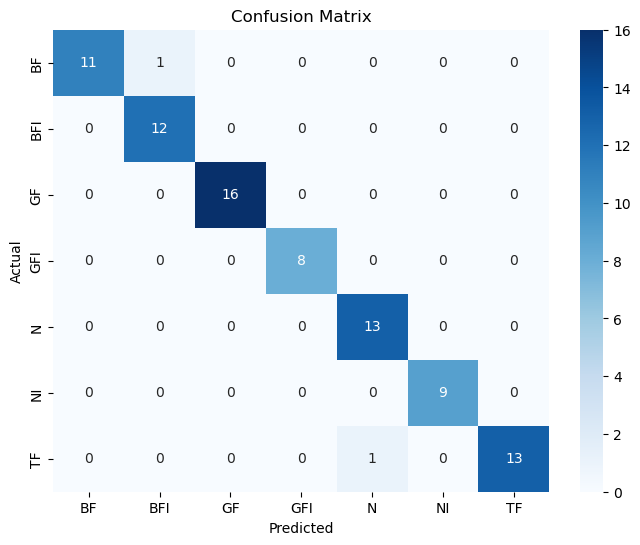

In [100]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


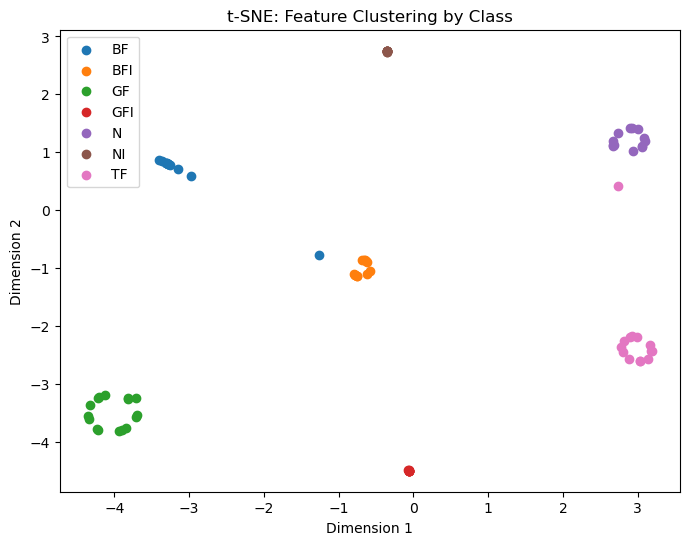

In [101]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(np.array(all_probs))  # shape: (N, 2)

plt.figure(figsize=(8,6))
for i in range(num_classes):
    idxs = np.array(all_labels) == i
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=class_names[i])
plt.legend()
plt.title("t-SNE: Feature Clustering by Class")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


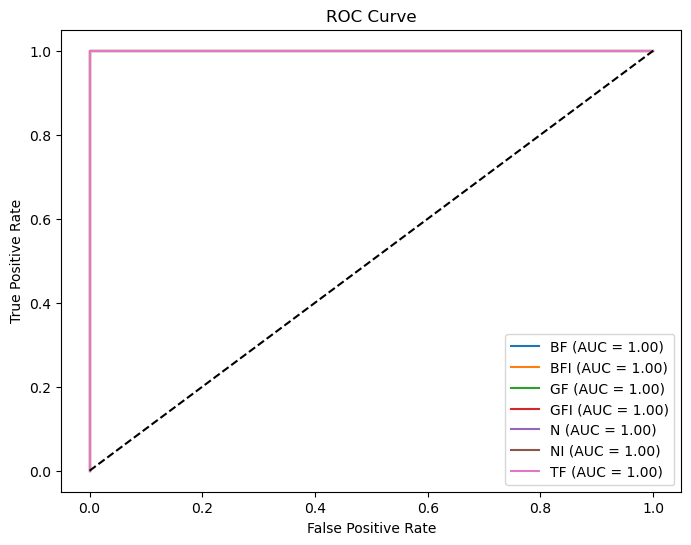

In [102]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [103]:
# Create class_to_idx dictionary
class_to_idx = dataset.class_to_idx  # From ImageFolder
idx_to_class = {v: k for k, v in class_to_idx.items()}


              precision    recall  f1-score   support

          BF       1.00      0.92      0.96        12
         BFI       0.92      1.00      0.96        12
          GF       1.00      1.00      1.00        16
         GFI       1.00      1.00      1.00         8
           N       0.93      1.00      0.96        13
          NI       1.00      1.00      1.00         9
          TF       1.00      0.93      0.96        14

    accuracy                           0.98        84
   macro avg       0.98      0.98      0.98        84
weighted avg       0.98      0.98      0.98        84



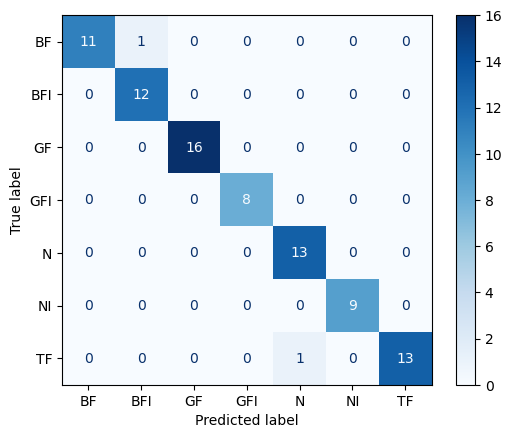

In [104]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # logits from final layer
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Run evaluation
y_true, y_pred = evaluate_model(model, val_loader, device)

# Classification report
print(classification_report(y_true, y_pred, target_names=list(class_to_idx.keys())))

# Confusion Matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_true, y_pred),
    display_labels=list(class_to_idx.keys())
)
disp.plot(cmap='Blues')
plt.show()


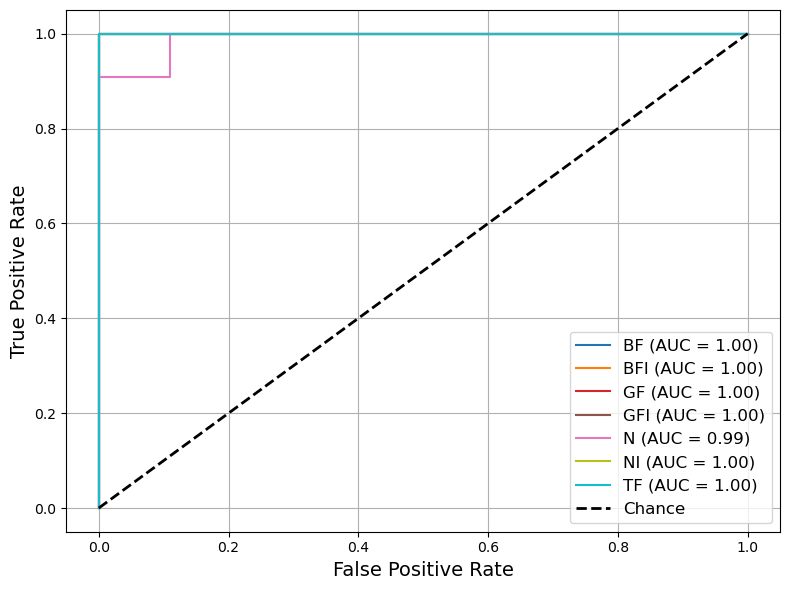

In [79]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(model, dataloader, class_names, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)  # logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)

    y_true = label_binarize(all_labels, classes=range(len(class_names)))

    plt.figure(figsize=(8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})', color=colors[i])

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)

    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot ROC
plot_roc_curves(model, val_loader, list(class_to_idx.keys()), device)


In [80]:
def extract_features(model, dataloader, device):
    """
    Extract deep features from the attention layer for t-SNE visualization.
    """
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            x = model.backbone(inputs)             # [B, 512, 7, 7]
            x = model.pool(x)                      # [B, 512, 1, 1]
            x = x.view(x.size(0), 1, -1)           # [B, 1, 512]
            x = model.attn(x)                      # [B, 1, 512]
            x = x.squeeze(1)                       # [B, 512]

            features.append(x.cpu().numpy())
            labels.append(targets.cpu().numpy())

    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels


In [81]:
def plot_tsne(features, labels, class_names):
    """
    Plot t-SNE visualization with seaborn and color-coded classes.
    """
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    # Convert numeric labels to class names
    class_labels = [class_names[label] for label in labels]

    # Define the colormap
    cmap = plt.cm.get_cmap("tab20")

    # Plot the t-SNE results
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=class_labels,
        palette=cmap(np.linspace(0, 1, len(class_names))),
        legend="full",
        s=80,
        alpha=0.9,
        edgecolor="black",
        linewidth=0.5
    )

    plt.legend(title="Classes", fontsize=10, loc='best')
    plt.tight_layout()
    # plt.savefig("results/tsne_attention.png", dpi=300)
    plt.show()


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_23164\2642362877.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")
C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_23164\2642362877.py:16: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(


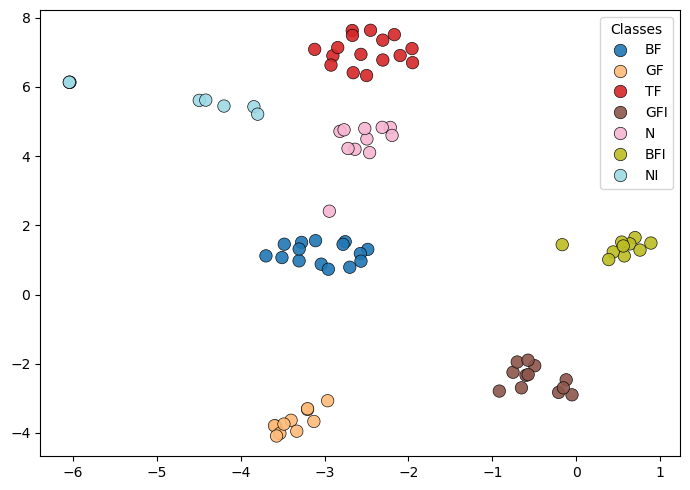

In [82]:
# Extract and plot t-SNE
test_features, test_labels = extract_features(model, val_loader, device)
plot_tsne(test_features, test_labels, list(class_to_idx.keys()))
